Введение

Прогноз снижения покупательской активности интернет-магазина «В один клик»

Отчёт магазина «В один клик» за прошлый период показал, что активность покупателей начала снижаться.

Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.

Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

План работы:

[1 Загрузка данных](#section1)

[2 Предобработка данных](#section2)

[3 Исследовательский анализ данных](#section3)

[4 Объединение таблиц](#section4)

[5 Корреляционный анализ данных](#section5)

[6 Использование пайплайнов](#section6) 

[7 Анализ важности признаков ](#section7) 

[8 Сегментация покупателей](#section8) 

[Общий вывод](#section10) 

<a id='section1'></a> 
##  Загрузка данных

Импортируем библиотеки.

In [1]:
!pip install phik -q

ERROR: Could not find a version that satisfies the requirement phik (from versions: none)
ERROR: No matching distribution found for phik


In [2]:
!pip install shap -q

ERROR: Could not find a version that satisfies the requirement shap (from versions: none)
ERROR: No matching distribution found for shap


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
import shap
from matplotlib import rcParams
from scipy import stats as st
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC  
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance


from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler
)

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    accuracy_score,
    confusion_matrix,
    recall_score,
    precision_score,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay
)
    
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from shap import Explanation
from shap.plots import waterfall, beeswarm
from sklearn.impute import SimpleImputer 

ModuleNotFoundError: No module named 'phik'

Загружаем данные о поведении покупателя на сайте.

In [ ]:
try:
    data_market = pd.read_csv('/datasets/market_file.csv',sep = ',')
except:
    data_market = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv',sep = ',')

Загружаем данные о выручке, которую получает магазин с покупателя.

In [ ]:
try:
    data_money = pd.read_csv('/datasets/market_money.csv',sep = ',')
except:
    data_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv',sep = ',')

Загружаем данные о времени в минутах, которое покупатель провел на сайте в течение периода.

In [ ]:
try:
    data_time = pd.read_csv('/datasets/market_time.csv',sep = ',')
except:
    data_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv',sep = ',')

Загружаем данные о среднемесячной прибыли покупателя за последние три месяца.

In [ ]:
try:
    data_money_3 = pd.read_csv('/datasets/money.csv',sep = ';', decimal = ',')
except:
    data_money_3 = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv',sep = ';', decimal = ',')

In [ ]:
display(data_market.head())
display(data_money.head())
display(data_time.head())
display(data_money_3.head())

<a id='section2'></a> 
## Предобработка данных

Выведем общую информацию о датафреймах.

In [ ]:
s=[data_market,data_money,data_time,data_money_3]

In [ ]:
for i in s:
    i.info()
    print()

Пропусков в данных нет.

Исследуем данные на полные дубликаты.

In [ ]:
for i in s:
    display(i.duplicated().sum())

Полных дубликатов в данных нет.

<a id='section3'></a> 
##  Исследовательский анализ данных

### Проведем анализ датафрейма data_market.

#### Построим гистограммы для численных столбцов.

In [ ]:
data_market.drop('id',axis=1).hist(figsize=(10, 15));

Явных выбросов в данных не наблюдается. 

В столбце "Акционные покупки" данные делятся на два кластера, один с центром 0.25, другой с центром чуть меньше 1.
Для этого столбца построим отдельную гистограмму для наглядности.

In [ ]:
data_market['Акционные_покупки'].hist(bins=30, figsize=(10,6))

plt.title('Распределение среднемесячной доли покупок по акции от общего числа покупок за последние 6 мес.') 
plt.xlabel('доля покупок')
plt.ylabel('число клиентов')

plt.show()

Действительно, большинство значений акционных покупок (среднемесячной доли покупок по акциям от общего числа покупок за последние 6 месяцев) принимает значения от 0.1 до 0.4, но есть небольшой пик значений от 0.9 до 1.

#### Теперь представим графически категориальные переменные датафрейма data_market.

Прежде всего проверим сбалансированность целевого признака.

In [ ]:
# Строим столбчатую диаграмму для 'Покупательской активности'
freqs = data_market['Покупательская активность'].value_counts()

ax = freqs.plot.bar(figsize=(6,4))

plt.title('Покупательская активность в абсолют.знач.') 
plt.ylabel('доля клиентов')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Строим столбчатую диаграмму для 'Покупательской активности'
freqs = data_market['Покупательская активность'].value_counts(normalize=True)

ax = freqs.plot.bar(figsize=(6,4))

plt.title('Покупательская активность в долях') 
plt.ylabel('доля клиентов')
plt.xticks(rotation=45)
plt.show()

Отношение классов примерно 3 к 2, поэтому нельзя сказать, что наблюдается сильный дисбаланс классов.

Построим столбчатую диаграмму для "Тип сервиса"

In [ ]:
# Строим столбчатую диаграмму для Тип сервиса
freqs = data_market['Тип сервиса'].value_counts()

ax = freqs.plot.bar(figsize=(6,4))

plt.title('Тип сервиса') 
plt.ylabel('число клиентов')
plt.xticks(rotation=45)
plt.show()

В столбце обнаружились неявные дубли, заменим в нем 'стандартт' на'стандарт'.

In [ ]:
data_market['Тип сервиса'] = data_market['Тип сервиса'].replace('стандартт','стандарт', regex=True)

In [ ]:
freqs = data_market['Тип сервиса'].value_counts()

ax = freqs.plot.bar(figsize=(6,4))

plt.title('Тип сервиса') 
plt.ylabel('число клиентов')
plt.xticks(rotation=45)
plt.show()

Сервис "стандарт" выбирает больше чем в два раза больше клиентов, чем "премиум". 

Посмотрим на согласия покупателей на дополнительные предложения о товарах.

In [ ]:
# Строим столбчатую диаграмму для Разрешить сообщать
freqs = data_market['Разрешить сообщать'].value_counts()

ax = freqs.plot.bar(figsize=(6,4))

plt.title('Cогласие на сообщения') 
plt.ylabel('число клиентов')
plt.xticks(rotation=45)
plt.show()

Дали согласие почти 1000 клиентов, не дали чуть менее 400.

Посмотрим на самые популярные категории товаров у покупателей за последние 6 месяцев.

In [ ]:
plt.figure(figsize=(20,20))
sns.catplot(data=data_market, y="Популярная_категория", kind="count")
plt.xlim(0,300)

Самой популярной категорией оказались "товары для детей", потом "домашний текстиль", "косметика и аксессуары". Меньше всего заказывали "кухонную посуду".

Выведем еще раз общую информацию о data_market.

In [ ]:
data_market.info()

### Исследуем данные о выручке 

Датафрейм data_money имеет неудобный для работы вид: для каждого id три строчки с выручкой за предпред- , пред- и текущий месяц.

In [ ]:
display(data_money.head(5))

В data_money создадим три столбца: "выручка_ предпред_ мес", "выручка_ пред_ мес" и "выручка_ тек_ мес".

In [ ]:
data_money['выручка_предпред_мес']=data_money['Выручка']*(data_money['Период']=='препредыдущий_месяц')
data_money['выручка_пред_мес']=data_money['Выручка']*(data_money['Период']=='предыдущий_месяц')
data_money['выручка_тек_мес']=data_money['Выручка']*(data_money['Период']=='текущий_месяц')

Теперь удалим столбцы 'Период' и 'Выручка' из data_money.

In [ ]:
data_money=data_money.drop(['Период','Выручка'],axis=1)

Сгруппируем данные по id, чтобы для каждого пользователя осталась одна строчка вместо трех.

In [ ]:
data_money=data_money.pivot_table(index='id',values=['выручка_предпред_мес','выручка_пред_мес','выручка_тек_мес'],aggfunc='sum')\
.reset_index()

display(data_money.head(5))
data_money.columns

Отберем клиентов с покупательской активностью не менее трех месяцев, то есть тех, у которых все столбцы с выручкой ненулевые.

In [ ]:
data_money=data_money[(data_money['выручка_предпред_мес']!=0)\
                      &(data_money['выручка_пред_мес']!=0)\
                      &(data_money['выручка_тек_мес']!=0)]

Посмотрим, сколько данных мы  потеряли после данного отбора.

In [ ]:
data_money.info()

Итого, было 1300 клиентов, стало 1297, небольшая потеря для исходных данных. 

Исследуем распределения выручки по каждому месяцу.

In [ ]:
data_money.drop('id',axis=1).hist(figsize=(10, 15));

Выручка в текущем месяце явно имеет выбросы. Построим диаграмму размаха.

In [ ]:
ax = data_money['выручка_тек_мес'].plot.box(figsize=(10,6))
plt.title('Диаграмма размаха для выручки в тек.мес.') 
plt.xlabel('выручка ') 
plt.ylabel('рубли') 
plt.show()


В данных есть явный выброс больше 100000 рублей. Возможно, был один крупный заказ, то есть значение может быть истинным, но для построения модели прогнозирования это нетипичное наблюдение лучше удалить.

In [ ]:
data_money=data_money[data_money['выручка_тек_мес']<40000]

In [ ]:
data_money['выручка_тек_мес'].hist(figsize=(6, 8))
plt.title('Распределение выручки в тек.мес.') 
plt.xlabel('выручка ') 
plt.ylabel('число клиентов') 
plt.show()


Теперь данные по выручке не содержат выбросов, похожи на нормальное распределение.

### Исследуем датафрейм data_time

Выведем первые строки.

In [ ]:
display(data_time.head())

В данных явно опечатка "предыдцщий_месяц" вместо "предыдущий_месяц".

Посмотрим, какие названия периодов встречаются в data_time['Период'].

In [ ]:
data_time['Период'].unique()

Заменим 'предыдцщий_ месяц' на 'предыдущий_ месяц'.

In [ ]:
data_time['Период']=data_time['Период'].replace('предыдцщий_месяц','предыдущий_месяц',regex=True)

Теперь в таблице правильные названия периодов.

Но для каждого id две строчки: с временем за предыдущий и текущий месяц. 

Создадим в таблице data_time два столбца: "время_ пред_ мес" и "время_ тек_ мес".

In [ ]:
data_time['время_пред_мес']=data_time['минут']*(data_time['Период']=='предыдущий_месяц')
data_time['время_тек_мес']=data_time['минут']*(data_time['Период']=='текущий_месяц')

In [ ]:
display(data_time.head())

В таблице data_time удалим столбцы "Период" и "минут", они нам больше не понадобятся.

In [ ]:
data_time=data_time.drop(['Период','минут'],axis=1)

Сформируем сводную таблицу по id, чтобы для каждого пользователя осталась одна строка вместо двух.

In [ ]:
data_time=data_time.pivot_table(index='id',values=['время_пред_мес','время_тек_мес'],aggfunc='sum').reset_index()
display(data_time.head(5))

Теперь для каждого id осталась одна строчка, но в каждой строке две переменных.

Выведем общую информацию о data_time.

In [ ]:
data_time.info()

In [ ]:
data_time['время_пред_мес'].hist()
plt.title('Распределение клиентов по времени, проведен. на сайте в пред.мес.') 
plt.xlabel('время, мин.') 
plt.ylabel('число клиентов') 
plt.show()

In [ ]:
data_time['время_тек_мес'].hist()
plt.title('Распределение клиентов по времени, проведен. на сайте в тек.мес.') 
plt.xlabel('время, мин.') 
plt.ylabel('число клиентов') 
plt.show()

### Исследуем датафрейм data_money_3

data_money_3 содержит данные о прибыли от каждого покупателя.

Построим гистограмму распределения среднемесячной прибыли покупателя за последние три месяца.

In [ ]:
data_money_3['Прибыль'].plot(kind='hist',figsize=(6,6))
plt.title('Распределение среднемесячной прибыли от покупателей за последние 3 месяца') 
plt.xlabel('среднемесяч. прибыль от покупателя, тыс.руб.')
plt.ylabel('число клиентов')
plt.show()

Данные похожи на нормальное распределение, выбросов не наблюдается.

<a id='section4'></a>
## Объединение таблиц

Теперь объединим таблицы data_market, data_money и data_time по id, используя функцию merge, чтобы объединить данные из внутренней области (которые есть во всех датафреймах).

Полученный датафрейм назовем data.

In [ ]:
data=pd.merge(data_market,data_money,how='inner', on='id')

In [ ]:
data=pd.merge(data,data_time,how='inner', on='id')

In [ ]:
display(data.head())

Выведем общую информацию о data.

In [ ]:
data.info()

Итого, датафрейм data содержит 1297 строк, столько же, сколько data_money, значит объединение прошло правильно.

<a id='section5'></a> 
## Корреляционный анализ

Поскольку не все признаки распределены нормально, рассчитаем для численных признаков коэффициенты корреляции Спирмена.

<AxesSubplot:>

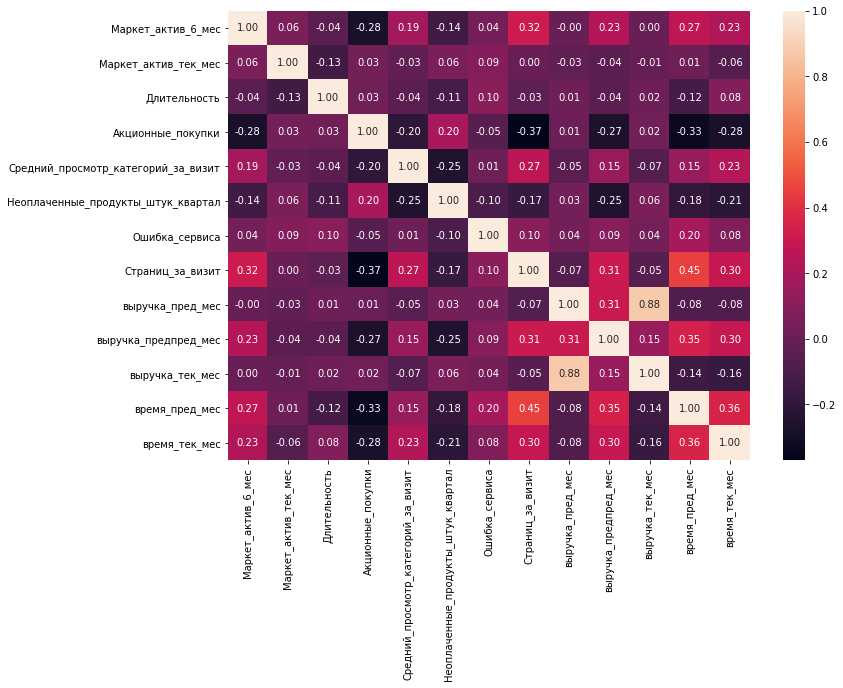

In [47]:
data_1=data.drop('id',axis=1)

rcParams['figure.figsize'] = 11.7,8.27
sns.heatmap(data_1.corr(method='spearman'), annot=True, fmt='.2f')
plt.show()

Теперь рассчитаем коэффициенты корреляции Фи между всеми признаками (числовыми и категориальными) средствами библиотеки phik. 

In [48]:
data_1.phik_matrix(interval_cols=['Маркет_актив_6_мес','Маркет_актив_тек_мес','Длительность','Акционные_покупки',\
                                  'Средний_просмотр_категорий_за_визит','Неоплаченные_продукты_штук_квартал',\
                                  'Ошибка_сервиса',' Страниц_за_визит','выручка_пред_мес','выручка_предпред_мес',\
                                 'выручка_тек_мес','время_пред_мес','время_тек_мес']).style.background_gradient(cmap="RdYlGn")

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_пред_мес,выручка_предпред_мес,выручка_тек_мес,время_пред_мес,время_тек_мес
Покупательская активность,1.000000,0.129940,0.000000,0.544831,0.000000,0.099901,0.506276,0.299717,0.539607,0.505655,0.224154,0.747331,0.224638,0.497393,0.197213,0.685138,0.576770
Тип сервиса,0.129940,1.000000,0.289965,0.089911,0.045258,0.401411,0.030010,0.070809,0.185391,0.120027,0.079515,0.087776,0.000000,0.069704,0.124216,0.131814,0.000000
Разрешить сообщать,0.000000,0.289965,1.000000,0.000000,0.052618,0.253831,0.012198,0.073684,0.070359,0.195982,0.021839,0.097094,0.080842,0.000000,0.060907,0.038387,0.000000
Маркет_актив_6_мес,0.544831,0.089911,0.000000,1.000000,0.079854,0.000000,0.279553,0.150386,0.206788,0.289421,0.142401,0.376035,0.155476,0.315331,0.039795,0.363950,0.330601
Маркет_актив_тек_мес,0.000000,0.045258,0.052618,0.079854,1.000000,0.174233,0.000000,0.136243,0.246633,0.144203,0.116946,0.000000,0.051824,0.000000,0.000000,0.107945,0.061410
Длительность,0.099901,0.401411,0.253831,0.000000,0.174233,1.000000,0.000000,0.000000,0.186795,0.192611,0.175608,0.128089,0.125572,0.113200,0.147048,0.026448,0.101481
Акционные_покупки,0.506276,0.030010,0.012198,0.279553,0.000000,0.000000,1.000000,0.122385,0.199180,0.237962,0.000000,0.350714,0.060733,0.226381,0.071094,0.262324,0.250558
Популярная_категория,0.299717,0.070809,0.073684,0.150386,0.136243,0.000000,0.122385,1.000000,0.226116,0.248620,0.000000,0.177637,0.252097,0.043528,0.237240,0.195233,0.089883
Средний_просмотр_категорий_за_визит,0.539607,0.185391,0.070359,0.206788,0.246633,0.186795,0.199180,0.226116,1.000000,0.325578,0.070315,0.293781,0.098440,0.176828,0.092597,0.159837,0.182568
Неоплаченные_продукты_штук_квартал,0.505655,0.120027,0.195982,0.289421,0.144203,0.192611,0.237962,0.248620,0.325578,1.000000,0.032907,0.373799,0.249171,0.261016,0.230022,0.256632,0.232383


Целевой признак "Покупательская активность" больше всего коррелирует с "Страниц_за_визит" (коэф.корр. Фи 0.75), "время_пред_мес" (0.69), "время_тек_мес"(0.58). 

Средний уровень корреляции Фи (около 0.5) у целевого признака с  "Маркет_актив_6_мес", "Акционные_покупки", "Средний_просмотр_категорий_за_визит",  "Неоплаченные_продукты_штук_квартал", "выручка_предпред_мес". 

Маленькая корреляция (0.1-0.3) у целевого признака с "Тип сервиса", "Длительность", "Популярная_категория", 	"Ошибка_сервиса", "выручка_пред_мес". 

Нет корреляции с "Разрешить сообщать", "Маркет_актив_тек_мес", "выручка_тек_мес".

Мультиколлинеарности между признаками не наблюдается.

<a id='section6'></a> 
## Использование пайплайнов

### Подготовка даных

Пусть 0 соответствует прежнему уровню покупательской активности, 1 - снижению.

In [49]:
data['Покупательская активность']=(data['Покупательская активность']=='Снизилась')*1

In [50]:
display(data.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_пред_мес,выручка_предпред_мес,выручка_тек_мес,время_пред_мес,время_тек_мес
0,215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


Для подготовки данных создадим пайплайн с использованием ColumnTransformer.

Формируем тренировочную и тестовую выборку.

In [51]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(
        ['Покупательская активность','id'], 
        axis=1
    ),
    data['Покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
)

Создаем списки количественных и категориальных  переменных. 

Переменную  "Тип сервиса" объявим категориальной упорядоченной.

In [52]:
#категориальные признаки
ohe_columns = [
     'Разрешить сообщать', 'Популярная_категория'
]
ord_columns = [
    'Тип сервиса' 
]

#количественные признаки
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес','Длительность','Акционные_покупки',\
               'Средний_просмотр_категорий_за_визит','Неоплаченные_продукты_штук_квартал','Ошибка_сервиса',\
              'Страниц_за_визит','выручка_пред_мес','выручка_предпред_мес','выручка_тек_мес',\
              'время_пред_мес','время_тек_мес']


 Создаём пайплайн для подготовки признаков из списка ohe_columns с помощью OHE-кодирования.

In [53]:
ohe_pipe = Pipeline(
    [
        (
            'ohe', 
 #           OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
            OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
        )
    ]
)


Добавляем пайплайн для Ordinal-кодирования.

In [54]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'], 
                   
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

Создаём общий пайплайн для подготовки данных категориальных и количественных переменных.

In [55]:
data_preprocessor = ColumnTransformer(
   transformers = [
      ('ohe', ohe_pipe, ohe_columns),
      ('ord', ord_pipe, ord_columns),
      ('num', StandardScaler(), num_columns)
   ])

<a id='section9'></a>
### Создадим пайплайн для поиска лучшей модели.

Чтобы найти лучшее решение, будем перебирать и модели, и их гиперпараметры, и методы подготовки данных. 

 Элементы для перебора зададим в словаре: 

In [73]:
param_distributions = [
    # словарь для модели KNeighborsClassifier() 
    {
        # название модели
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(1, 10),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE,probability=True)],
        'models__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE,penalty='l1')],
        'models__C': [0.5,1,2,3,4,5,6,7,8,9,10],
        'models__solver': ['liblinear', 'saga'], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
] 

 Используем случайный поиск для поиска наилучшей модели, метрику используем ROC-AUC, поскольку она учитывает работу модели при всех возможных значениях порогов. Кроме того, она хорошо работает с несбалансированной выборкой, у хотя у нас нет сильного дисбаланса целевого признака, но соотношение классов 3:2, поэтому на всякий случай будем  использовать эту метрику.

In [74]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [75]:
randomized_search_all = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_all.fit(X_train, y_train) 

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse=False))]),
                                                                               ['Разрешить '
                                                                                'сообщать',
                                                                                'Популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_or

In [76]:
print('Лучшая модель и её параметры:\n\n', randomized_search_all.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                  

Лучшей моделью стала логистическая регрессия с l1 регуляризацией, параметром С = 7 и алгоритмом перебора liblinear.

In [77]:
print('Метрика ROC-AUC для лучшей модели:\n', randomized_search_all.best_score_)

Метрика ROC-AUC для лучшей модели:
 0.8983470717405961


Выведем все результаты для лучших по рейтингу качества моделей:

In [78]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(randomized_search_all.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')) 


,rank_test_score,param_models,mean_test_score,params
7,1,"LogisticRegression(C=7, penalty='l1', random_state=42, solver='liblinear')",0.898347,"{'preprocessor__num': MinMaxScaler(), 'models__solver': 'liblinear', 'models__C': 7, 'models': LogisticRegression(C=7, penalty='l1', random_state=42, solver='liblinear')}"
3,2,"LogisticRegression(C=7, penalty='l1', random_state=42, solver='liblinear')",0.897744,"{'preprocessor__num': 'passthrough', 'models__solver': 'liblinear', 'models__C': 5, 'models': LogisticRegression(C=7, penalty='l1', random_state=42, solver='liblinear')}"
2,3,"SVC(probability=True, random_state=42)",0.896022,"{'preprocessor__num': 'passthrough', 'models__kernel': 'linear', 'models': SVC(probability=True, random_state=42)}"
1,4,"SVC(probability=True, random_state=42)",0.895945,"{'preprocessor__num': StandardScaler(), 'models__kernel': 'linear', 'models': SVC(probability=True, random_state=42)}"
4,5,KNeighborsClassifier(),0.874659,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 3, 'models': KNeighborsClassifier()}"
0,6,DecisionTreeClassifier(random_state=42),0.843052,"{'preprocessor__num': StandardScaler(), 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"
8,7,DecisionTreeClassifier(random_state=42),0.835243,"{'preprocessor__num': MinMaxScaler(), 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
5,8,DecisionTreeClassifier(random_state=42),0.813853,"{'preprocessor__num': MinMaxScaler(), 'models__max_depth': 9, 'models': DecisionTreeClassifier(random_state=42)}"
6,9,"LogisticRegression(C=7, penalty='l1', random_state=42, solver='liblinear')",0.653388,"{'preprocessor__num': 'passthrough', 'models__solver': 'saga', 'models__C': 0.5, 'models': LogisticRegression(C=7, penalty='l1', random_state=42, solver='liblinear')}"
9,10,"SVC(probability=True, random_state=42)",0.606933,"{'preprocessor__num': MinMaxScaler(), 'models__kernel': 'sigmoid', 'models': SVC(probability=True, random_state=42)}"


### Подбор гиперпараметров для каждой модели

#### Подбор гиперпараметров для логистической регрессии

In [79]:
param_distributions = [
    
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, penalty='l1',max_iter=1000)],
        'models__C': [0.5,1,2,3,4,5,6,7,8,9,10],
        'models__solver': ['liblinear', 'saga'], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, penalty='l2',max_iter=100)],
        'models__C': [0.5,1,2,3,4,5,6,7,8,9,10],
        'models__solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
    
    
] 

In [80]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

In [81]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    cv=5,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) 

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_o

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse=False))]),
                                                                               ['Разрешить '
                                                                                'сообщать',
                                                                                'Популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[

In [82]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                  

In [83]:
print('Гиперпараметры',randomized_search.best_params_)

Гиперпараметры {'preprocessor__num': StandardScaler(), 'models__solver': 'lbfgs', 'models__C': 0.5, 'models': LogisticRegression(C=0.5, random_state=42)}


In [84]:
print('Метрика ROC-AUC для лучшей модели:\n', randomized_search.best_score_)

Метрика ROC-AUC для лучшей модели:
 0.8990889355335183


Лучшими гиперпараметрами для логистической регрессии стали C=5 (коэффициент, обратный силе регуляризации), алгоритм оптимизации 'saga', масштабирование с помощью MinMaxScaler().

Метрика ROC-AUC практически равна метрике лучшей модели 0.902.

#### Подбор гиперпараметров для KNeighborsClassifier()

In [85]:
param_distributions = [
    
   {   # название модели
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(1, 20),
        'models__weights': ['uniform', 'distance'],
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    }
] 

In [86]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', KNeighborsClassifier())
])

In [87]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    cv=5,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) 

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse=False))]),
                                                                               ['Разрешить '
                                                                                'сообщать',
                                                                                'Популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[

In [88]:
print('Гиперпараметры',randomized_search.best_params_)

Гиперпараметры {'preprocessor__num': StandardScaler(), 'models__weights': 'distance', 'models__n_neighbors': 13, 'models': KNeighborsClassifier(n_neighbors=13, weights='distance')}


In [89]:
print('Метрика ROC-AUC для лучшей модели:\n', randomized_search.best_score_)

Метрика ROC-AUC для лучшей модели:
 0.9137621995934573


Лучшими гиперпараметрами для модели к-соседей стали: число соседей 13, веса наблюдений определяются по расстояниям (weights= "distance"), масштабирование StandardScaler().

Интересно, что метрика ROC-AUC получилась даже больше, чем у лучшей модели (0.913 против 0.902). 

В поиске лучшей модели мы задали число соседей в промежутке (1, 10), чтобы поиск происходил быстрее, оказалось, что число соседей 13 оптимальнее с точки зрения метрики ROC-AUC.

#### Подбор гиперпараметров для SVC

In [90]:
param_distributions = [
    
   {
        'models': [SVC(random_state=RANDOM_STATE,probability=True)],
        'models__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    }
] 

In [91]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', SVC(random_state=RANDOM_STATE,probability=True))
])

In [92]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    cv=5,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) 

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse=False))]),
                                                                               ['Разрешить '
                                                                                'сообщать',
                                                                                'Популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[

In [93]:
print('Гиперпараметры',randomized_search.best_params_)

Гиперпараметры {'preprocessor__num': MinMaxScaler(), 'models__kernel': 'rbf', 'models': SVC(probability=True, random_state=42)}


In [94]:
print('Метрика ROC-AUC для лучшей модели:\n', randomized_search.best_score_)

Метрика ROC-AUC для лучшей модели:
 0.9028406859820309


Лучшим гиперпараметром стало ядро радиальной базисной функции 'rbf', масштабирование MinMaxScaler().

#### Подбор гиперпараметров для DecisionTreeClassifier

In [95]:
param_distributions = [
    
   {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 100),
        'models__min_samples_leaf': range(1, 10),
        'models__min_samples_split': range(2, 10),
        'models__max_depth': range(2, 100),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
] 

In [96]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [97]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    cv=5,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) 

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse=False))]),
                                                                               ['Разрешить '
                                                                                'сообщать',
                                                                                'Популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[

In [98]:
print('Гиперпараметры',randomized_search.best_params_)

Гиперпараметры {'preprocessor__num': 'passthrough', 'models__min_samples_split': 6, 'models__min_samples_leaf': 9, 'models__max_depth': 26, 'models': DecisionTreeClassifier(max_depth=26, min_samples_leaf=9, min_samples_split=6,
                       random_state=42)}


In [99]:
print('Метрика ROC-AUC для лучшей модели:\n', randomized_search.best_score_)

Метрика ROC-AUC для лучшей модели:
 0.883050697731582


Лучшие гиперпараметры для дерева решений : максимальная глубина дерева 26, миним. кол-во объектов в одном листе 9, миним. число объектов в узле 6, масштабирование MinMaxScaler().

Метрика ROC-AUC 0.87 - близка к метрике лучшей модели 0.902.

### Лучшая модель

Логистическая регрессия с l1 регуляризацией, параметром С = 7 и алгоритмом перебора liblinear.

<a id='section7'></a> 
## Анализ важности признаков

Лучшей моделью по результатам [п.6.2](#section9) была признана SVC с масштабированием по MinMaxScaler():

In [100]:
randomized_search_all.best_params_

{'preprocessor__num': MinMaxScaler(),
 'models__solver': 'liblinear',
 'models__C': 7,
 'models': LogisticRegression(C=7, penalty='l1', random_state=42, solver='liblinear')}

Вспомогательные шаги для подготовки тренировочной и тестовой выборки:

In [101]:
best_model = randomized_search_all.best_estimator_

In [102]:
preprocessor = best_model.named_steps['preprocessor']  
model = best_model.named_steps['models']              

In [103]:
#создаем список столбцов после категорирования и масштабирования
a=preprocessor.transformers_[0][1].named_steps['ohe'].get_feature_names()

b=ord_columns
c=num_columns

columns=pd.concat([pd.Series(a),pd.Series(b),pd.Series(c)])
column_names = list(columns)

print(columns)

0                                      x0_нет
1                    x1_Косметика и аксесуары
2                          x1_Кухонная посуда
3     x1_Мелкая бытовая техника и электроника
4           x1_Техника для красоты и здоровья
5                         x1_Товары для детей
0                                 Тип сервиса
0                          Маркет_актив_6_мес
1                        Маркет_актив_тек_мес
2                                Длительность
3                           Акционные_покупки
4         Средний_просмотр_категорий_за_визит
5          Неоплаченные_продукты_штук_квартал
6                              Ошибка_сервиса
7                            Страниц_за_визит
8                            выручка_пред_мес
9                        выручка_предпред_мес
10                            выручка_тек_мес
11                             время_пред_мес
12                              время_тек_мес
dtype: object


In [104]:
X_train_transformed =  pd.DataFrame(
    preprocessor.transform(X_train),
    columns=columns   
) 
X_test_transformed = pd.DataFrame(
    preprocessor.transform(X_test),
    columns=columns   
) 

Цель отбора признаков — найти те, которые вносят наибольший вклад в корректное предсказание. Это свойство называют важностью признаков (англ. feature importance).

У методов опорных векторов нет встроенных механизмов по работе с весами. Алгоритмы этих моделей работают с расчётом расстояний между объектами в пространстве признаков, поэтому им не нужно оценивать важность.

### permutation importance

Самый простой показатель для оценки важности признаков в моделях без встроенных весов является permutation importance, «важность после перестановки». Его применим к нашей лучшей модели.

             imp                                  columns
11  2.469136e-02      Средний_просмотр_категорий_за_визит
18  2.407407e-02                           время_пред_мес
14  2.314815e-02                         Страниц_за_визит
10  1.728395e-02                        Акционные_покупки
7   8.950617e-03                       Маркет_актив_6_мес
19  3.703704e-03                            время_тек_мес
17  2.160494e-03                          выручка_тек_мес
16  1.234568e-03                     выручка_предпред_мес
3   9.259259e-04  x1_Мелкая бытовая техника и электроника
1   0.000000e+00                 x1_Косметика и аксесуары
12 -3.330669e-17       Неоплаченные_продукты_штук_квартал
6  -3.086420e-04                              Тип сервиса
13 -9.259259e-04                           Ошибка_сервиса
2  -1.851852e-03                       x1_Кухонная посуда
5  -2.469136e-03                      x1_Товары для детей
4  -3.395062e-03        x1_Техника для красоты и здоровья
0  -4.938272e-

<AxesSubplot:ylabel='columns'>

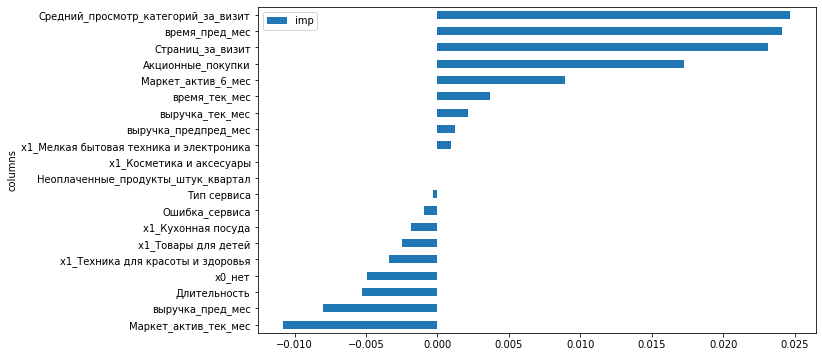

In [105]:
#вычисление коэффициентов важности признаков
results = permutation_importance(model, X_test_transformed, y_test, n_repeats=10, random_state=42)

#создание таблицы для удобного отображения вычисленных коэффициентов
imp=[]
for i, importance in enumerate(results.importances_mean):
#    display(f"Feature {i+1}:{column_names[i]}     {round(importance,4)} ")
    imp.append(importance)
    
imp=pd.Series(imp)
imp.reset_index(drop=True, inplace=True)
columns.reset_index(drop=True, inplace=True)

table =pd.concat([imp, columns],axis=1)

# создаем таблицу важности признаков
table = pd.DataFrame({
    'imp': imp,
    'columns': columns
})

sorted_df = table.sort_values(by='imp',ascending =False)
print(sorted_df)

table.sort_values(by='imp')
table.sort_values(by='imp').plot(x='columns', y='imp', kind='barh', figsize=(10, 6)) 
plt.show()

У нас получились некоторые значения отрицательные, Это связано с тем, что в этих случаях прогнозы по перетасованным данным оказались более точными, чем реальные данные.

Наибольшую важность имеют признаки "акционные покупки", "страниц за визит", "время_пред_мес" и "время_тек_мес".

Наименьшую важность имеют "тип сервиса", "разрешение на сообщения", а также категории "товары для детей", "косметика", "кухонная посуда" в признаке "популярная категория".

Попробуем убрать некоторые признаки и посмотреть, как измерится метрика roc-auc. 

Сначала уберем 7 наименее  важных признаков из 20.

In [106]:
X_train_transformed_new = X_train_transformed.iloc[:, [4, 5, 7,9, 10, 11, 12,13, 14,16,17, 18, 19]]
X_test_transformed_new = X_test_transformed.iloc[:, [4, 5, 7, 9,10, 11, 12,13, 14, 16,17,18, 19]]

model.fit(X_train_transformed_new, y_train)
    
roc_auc_score(y_test, model.predict(X_test_transformed_new))

0.8589466089466088

Теперь уберем 10 наименее  важных признаков из 20.

In [107]:
X_train_transformed_new = X_train_transformed.iloc[:, [4, 5, 7, 10, 11, 12,13, 14, 18, 19]]
X_test_transformed_new = X_test_transformed.iloc[:, [4, 5, 7, 10, 11, 12,13, 14, 18, 19]]

model.fit(X_train_transformed_new, y_train)
    
roc_auc_score(y_test, model.predict(X_test_transformed_new))

0.8629148629148629

Теперь уберем 13 признаков.

In [108]:
X_train_transformed_new = X_train_transformed.iloc[:, [4,  7, 10,  12, 14, 18, 19]]
X_test_transformed_new = X_test_transformed.iloc[:, [4, 7, 10,  12, 14, 18, 19]]


model.fit(X_train_transformed_new, y_train)
    
roc_auc_score(y_test, model.predict(X_test_transformed_new))


0.8499278499278499

Уберем 15, оставим 5.

In [109]:
X_train_transformed_new = X_train_transformed.iloc[:, [4,   10,   14, 18, 19]]
X_test_transformed_new = X_test_transformed.iloc[:, [4,  10,  14, 18, 19]]


model.fit(X_train_transformed_new, y_train)
    
roc_auc_score(y_test, model.predict(X_test_transformed_new))


0.8538961038961038

Перепроверим, вообще не будем убирать признаки.

In [110]:
X_train_transformed_new = X_train_transformed
X_test_transformed_new = X_test_transformed

model.fit(X_train_transformed_new, y_train)

roc_auc_score(y_test, model.predict(X_test_transformed_new))

0.8538961038961038

Удивительно, что метрика не совпала с наилучшей найденной с помощью randomized_search 0.902.

Пока опытным путем установлено, что можно убрать 10 признаков, и метрика roc_auc улучшится на 0.02.

### SHAP

Однозначную оценку вклада признака в каждый прогноз показывают значения Шепли, их оценивают методом SHAP. 

Рассчитаем SHAP значения.

In [111]:
# Оптимизация фонового набора данных (снижаем количество до 30 точек)
background = shap.sample(X_train_transformed, 30)

In [112]:
# Создаем SHAP Explainer
explainer = shap.KernelExplainer(model.predict_proba, background)

In [113]:
# Вычисляем значения SHAP (используем первые 30 наблюдений для скорости)
shap_values = explainer.shap_values(X_test_transformed[:30])


  0%|          | 0/30 [00:00<?, ?it/s]

In [114]:
#display(X_test_transformed[:30])

Посмотрим, как выглядят эти значения.

In [115]:
print(shap_values)

[[[-0.00904585  0.00904585]
  [ 0.          0.        ]
  [-0.00497603  0.00497603]
  ...
  [ 0.00335378 -0.00335378]
  [-0.03730496  0.03730496]
  [ 0.00617644 -0.00617644]]

 [[-0.00714192  0.00714192]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ...
  [-0.03038158  0.03038158]
  [-0.04326008  0.04326008]
  [-0.04851802  0.04851802]]

 [[-0.01280228  0.01280228]
  [ 0.          0.        ]
  [ 0.04807017 -0.04807017]
  ...
  [ 0.01798842 -0.01798842]
  [ 0.05204272 -0.05204272]
  [-0.14440847  0.14440847]]

 ...

 [[-0.01277804  0.01277804]
  [ 0.          0.        ]
  [-0.00729432  0.00729432]
  ...
  [ 0.02106231 -0.02106231]
  [-0.12653133  0.12653133]
  [-0.07471913  0.07471913]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.01295327 -0.01295327]
  ...
  [ 0.          0.        ]
  [ 0.04598183 -0.04598183]
  [ 0.05361982 -0.05361982]]

 [[-0.00839312  0.00839312]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ...
  [-0.00996855  0.009968

In [116]:
shap_values.shape

(30, 20, 2)

shap_values представляет собой трехмерный массив, где первое измерение - номер наблюдения, второе - номер признака, третье - номер класса предсказания. 

У нас  класс 0 соответствует "прежнему" уровню активности, класс 1 - снижению активности.

Для  каждого из 20 признаков  можем посмотреть его вклад в полученное значение прогноза для 1 класса для каждого из 30 наблюдений.

In [117]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[..., 1], X_test_transformed)

Отобразим вклад каждого признака в классификацию всех наблюдений.
На оси X отложены значения Шепли, на оси Y — признаки модели, расположенные сверху вниз в порядке убывания средних SHAP‑значений.

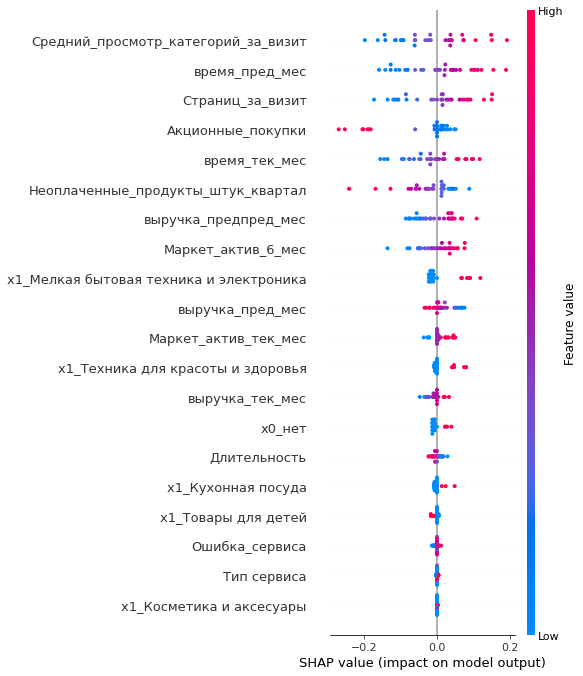

In [118]:
shap.summary_plot(shap_values[...,0], X_test_transformed[:30], feature_names=X_test_transformed.columns)

Негативные значения Шепли слева от центральной вертикальной линии означают, что признак склоняет модель отнести объекты к классу 0, а положительные справа — к классу 1.

Цвет точки отражает значения каждого признака объекта: чем краснее объект, тем больше признак, указанный на оси Y.

По нашей диаграмме на снижение покупательской активности (то есть отнесение к 1 классу) больше всего повлияли "число страниц за визит", "время_пред_мес", "средний просмотр категорий за визит", "время_тек_мес".
    
"акционные покупки" имеют больший вес при отнесении прогноза к классу 0.

Построим столбчатую диаграмму, которая  отражает общий вклад признаков в прогнозы модели. Она показывает средние SHAP-значения признака по всем наблюдениям. Для расчёта средних берут значения Шепли по модулю, чтобы положительные и отрицательные значения не сводили друг друга к нулю.

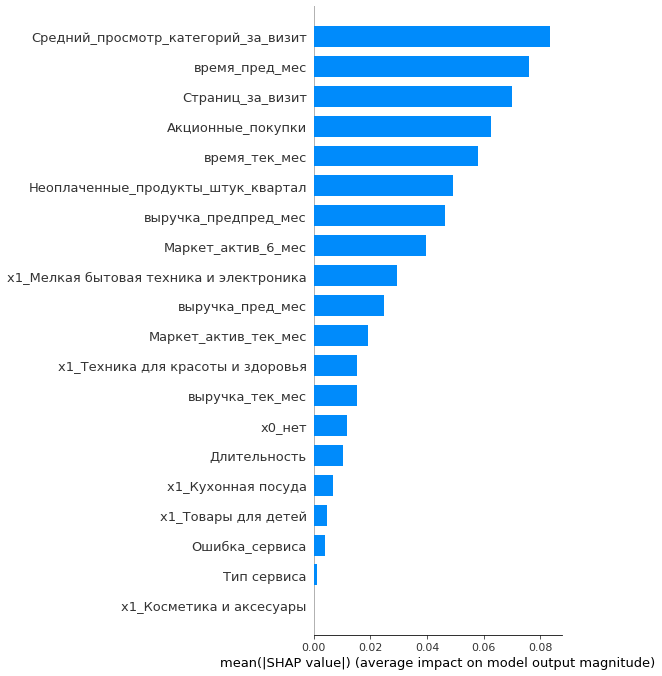

In [119]:
shap.summary_plot(shap_values[...,0],X_train_transformed[:30],plot_type="bar")


Наибольшие значения имеют уже перечисленные признаки. 

Диаграмма shap.plots.waterfall визуализирует индивидуальные SHAP-значения каждого наблюдения в датасете. 

Вот как будет выглядеть график для пятого объекта:

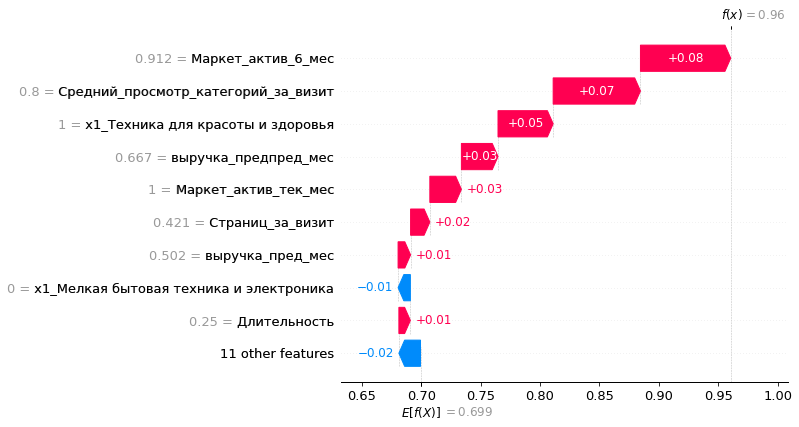

In [120]:
exp = Explanation(shap_values[...,0], explainer.expected_value[0], X_test_transformed[:30], feature_names=X_test_transformed.columns)
idx = 5
waterfall(exp[idx],max_display=10)

Таким образом, можно выделить признаки, сильно значимые для модели:

- среднее число просмотренных страниц за визит, 

- среднемесячная доля покупок по акции, 

- время, проведенное на сайте в предыдущий и текущий месяц,

- число категорий, просмотренных покупателем за визит.

Мало значимы для модели:

- категории посуда и товары для детей в признаке популярная категория

- число сбоев

- время с момента регистрации на сайте

- тип сервиса

- разрешение на сообщения

- выручка с покупателя за предыдущий месяц. 


Из приведенного анализа можно сформулировать рекомендации для бизнеса: чтобы увеличить покупательскую активность, необходимо увеличить активность пользователей на сайте (число страниц за просмотр, время, проведенное на сайте, число просмотренных категорий).  

<a id='section8'></a>
## Сегментация покупателей

По результатам анализа важности признаков среднее число просмотренных страниц за визит является сильно значимым признаком для модели. 

Проведем сегментацию покупателей по этому признаку с учетом данных о прибыли от каждого покупателя.

Рассчитаем для каждого покупателя вероятность снижения покупательской активности, занесем значения в новый столбец "Предсказ_знач".

In [121]:
#подготавливаем всю выборку покупетелей
X_transformed =  pd.DataFrame(
    preprocessor.transform( data.drop(
        ['Покупательская активность','id'], 
        axis=1
    )),
    columns=columns   
) 

In [122]:
pred=model.predict_proba(X_transformed)#получаем предсказания классов

In [123]:
data['Предсказ_знач']=list(pred[:, 1])#создаем столбец с вероятностями класса 1

Объединяем таблицу с данными о прибыли от покупателей за 3 месяца.
    
В сегмент возьмем клиентов, приносящих больше 3 тысяч в месяц, и с вероятностью снижения покупательской активности больше 70%.

In [124]:
data_full=pd.merge(data, data_money_3, how='inner', on='id')#объединяем с выручкой

In [125]:
seg1=data_full[(data_full['Предсказ_знач']>0.7) & (data_full['Прибыль']>3)]#сегмент

In [126]:
merged=data_full[(data_full['Предсказ_знач']<=0.7) |  (data_full['Прибыль']<=3)]#остальные клиенты

In [127]:
#выводим число покупателей в сегменте и остальных
print(f'сегмент {seg1.shape[0]}')
print(f'остальные {merged.shape[0]}')

сегмент 319
остальные 977


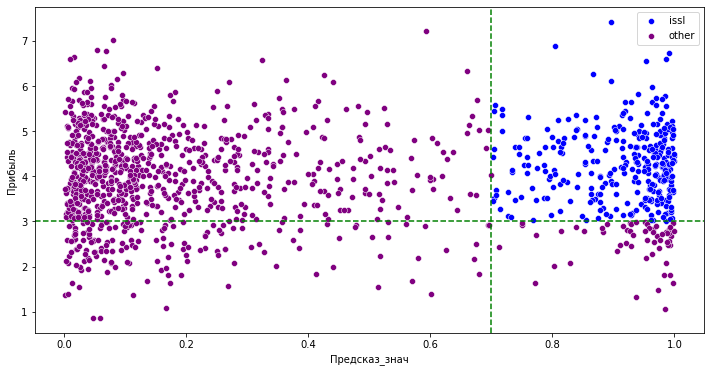

In [128]:
#диаграмма рассеяния по вероятности снижения покуп.актив. и приносимой прибыли
plt.figure(figsize=(12,6))
sns.scatterplot(data=seg1,x='Предсказ_знач',y='Прибыль',label='issl',color='blue')
sns.scatterplot(data=merged,x='Предсказ_знач',y='Прибыль',label='other',color='purple')
plt.legend()
plt.axvline(x=0.7, color='green',linestyle='--')
plt.axhline(y=3, color='green',linestyle='--')

Вспомним, что по акционным покупкам все покупатели делились на 2 кластера: с долей покупок по акции меньше 0,6 и больше 0,6.

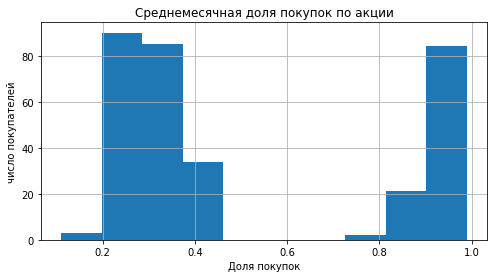

In [129]:
seg1['Акционные_покупки'].hist(figsize=(8,4))
plt.title('Среднемесячная доля покупок по акции') 
plt.xlabel('Доля покупок') 
plt.ylabel('число покупателей') 
plt.show()

Определим группу из сегмента, которая совершает мало покупок по акциям seg1_few_act, всех остальных из сегмента отнесем в seg1_much_act.
    
Для этих двух групп построим диаграммы распределения признаков, наиболее важных для лучшей модели.
    
Поскольку число покупателей в группах разное, строим гистограммы не в абсолютных, а относительных значениях, то есть отображаем долю покупателей с исследуемым признаком в своей группе, чтобы можно было корректно сравнивать полученные показатели.

In [130]:
seg1_few_act=seg1[seg1['Акционные_покупки']<0.6]

In [131]:
seg1_much_act=seg1[seg1['Акционные_покупки']>=0.6]

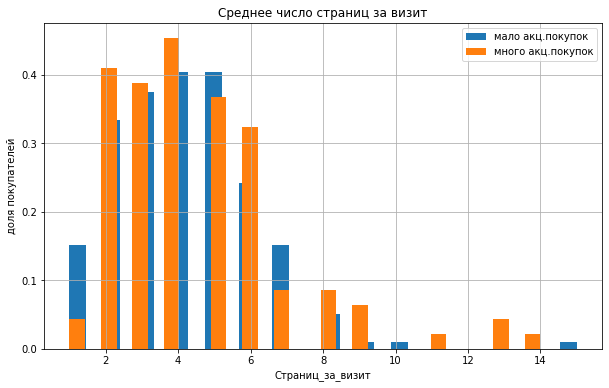

In [132]:
seg1_few_act['Страниц_за_визит'].hist(bins=30,figsize=(10,6),label='мало акц.покупок',density=1)
plt.title('Среднее число страниц за визит') 
plt.xlabel('Страниц_за_визит') 
plt.ylabel('доля покупателей')  
seg1_much_act['Страниц_за_визит'].hist(bins=30,figsize=(10,6),label='много акц.покупок',density=1)
plt.legend()
plt.show()

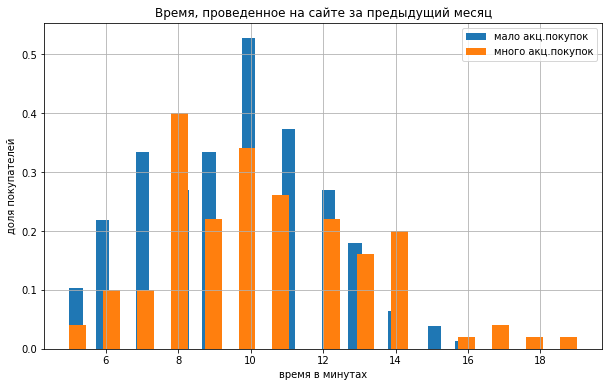

In [133]:
seg1_few_act['время_пред_мес'].hist(bins=30,figsize=(10,6),label='мало акц.покупок',density=1)
plt.title('Время, проведенное на сайте за предыдущий месяц') 
plt.xlabel('время в минутах') 
plt.ylabel('доля покупателей')  
seg1_much_act['время_пред_мес'].hist(bins=30,figsize=(10,6),label='много акц.покупок',density=1)
plt.legend()
plt.show()

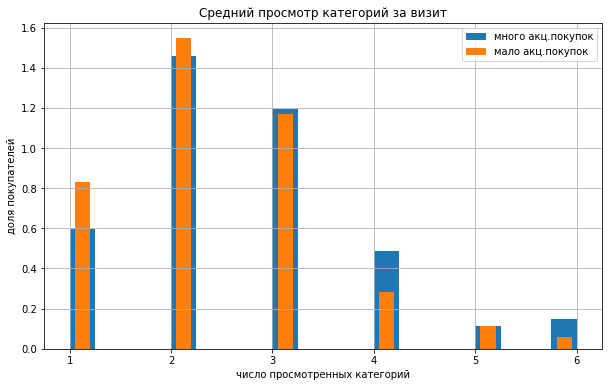

In [134]:
seg1_much_act['Средний_просмотр_категорий_за_визит'].hist(bins=20,figsize=(10,6),label='много акц.покупок',\
                                                          density=1,histtype='barstacked', rwidth=1.5 )
seg1_few_act['Средний_просмотр_категорий_за_визит'].hist(bins=20,figsize=(10,6),label='мало акц.покупок',\
                                                         density=1,histtype='barstacked', rwidth=0.6 )
plt.title('Средний просмотр категорий за визит') 
plt.xlabel('число просмотренных категорий') 
plt.ylabel('доля покупателей')  
#
plt.legend()
plt.show()

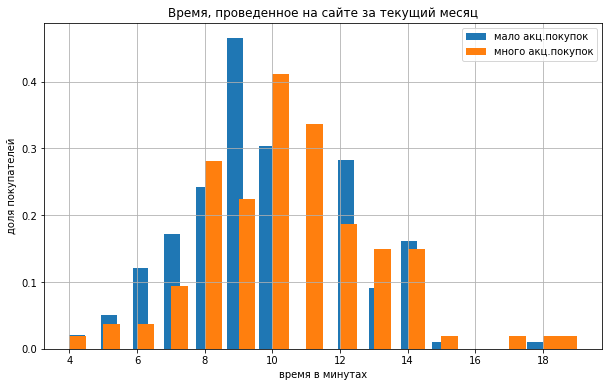

In [135]:
seg1_few_act['время_тек_мес'].hist(bins=30,figsize=(10,6),label='мало акц.покупок',density=1)
plt.title('Время, проведенное на сайте за текущий месяц') 
plt.xlabel('время в минутах') 
plt.ylabel('доля покупателей')  
seg1_much_act['время_тек_мес'].hist(bins=30,figsize=(10,6),label='много акц.покупок',density=1)
plt.legend()
plt.show()

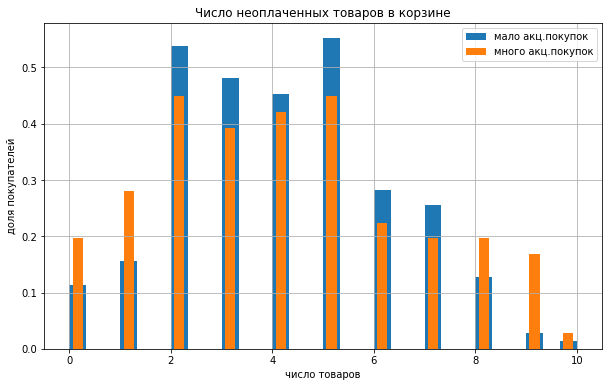

In [136]:
seg1_few_act['Неоплаченные_продукты_штук_квартал'].hist(bins=30,figsize=(10,6),label='мало акц.покупок',density=1,histtype='barstacked', rwidth=1.5)
plt.title('Число неоплаченных товаров в корзине') 
plt.xlabel('число товаров') 
plt.ylabel('доля покупателей')  
seg1_much_act['Неоплаченные_продукты_штук_квартал'].hist(bins=30,figsize=(10,6),label='много акц.покупок',density=1,histtype='barstacked', rwidth=0.6)
plt.legend()
plt.show()

Из приведенных диаграмм видно, что те, кто мало покупает по акциям, чаще останавливаются на просмотре только 1 страницы, и в целом меньше времени проводят на сайте: доля тех, кто просматривает сайт меньше 7 минут в среднем, среди "мало-акционных" в 2-3 раза выше, чем среди "много-акционных".
    
Соответственно, рекомендации будут по удержанию внимания "мало-акционных" покупателей на сайте,
возможно предложение персональных скидок на главной странице или кэшбека за купленные товары.

Вспомним, как распределено среднее число просмотренных страниц.

<AxesSubplot:ylabel='Frequency'>

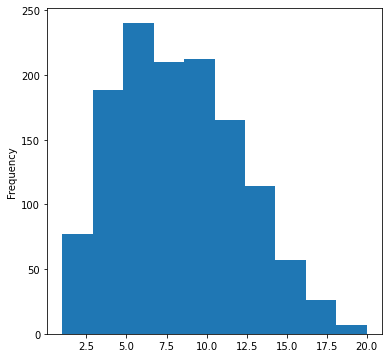

In [137]:
data['Страниц_за_визит'].plot(kind='hist',figsize=(6,6))
plt.title('Распределение среднего числа просмотренных страниц') 
plt.xlabel('число страниц')
plt.ylabel('число клиентов')
plt.show()

In [138]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   Покупательская активность            1296 non-null   int64  
 2   Тип сервиса                          1296 non-null   object 
 3   Разрешить сообщать                   1296 non-null   object 
 4   Маркет_актив_6_мес                   1296 non-null   float64
 5   Маркет_актив_тек_мес                 1296 non-null   int64  
 6   Длительность                         1296 non-null   int64  
 7   Акционные_покупки                    1296 non-null   float64
 8   Популярная_категория                 1296 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  Ошибка_сервиса                

По логике, чем меньше страниц просматривал пользователь, тем больше вероятность снижения его покупательской активности.

Поэтому в исследуемый сегмент отберем покупателей с числом просмотренных страниц меньше 5.

В то же время, нужно отследить тех из них, кто приносил компании наибольшую прибыль.

Объединим таблицы data и data_money_3  методом merge, чтобы в общую таблицу вошли только те  id, которые есть в обоих таблицах.

In [140]:
data2=pd.merge(data, data_money_3, how='inner', on='id')

Вспомним, как распределена прибыль по клиентам.

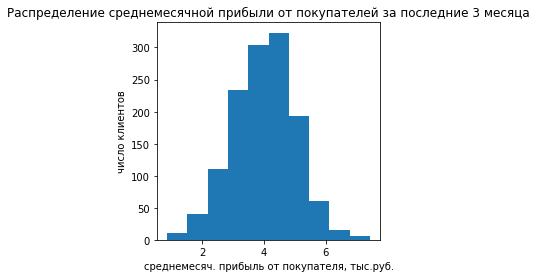

In [141]:
data_money_3['Прибыль'].plot(kind='hist',figsize=(4,4))
plt.title('Распределение среднемесячной прибыли от покупателей за последние 3 месяца') 
plt.xlabel('среднемесяч. прибыль от покупателя, тыс.руб.')
plt.ylabel('число клиентов')
#plt.xticks(rotation=30)
plt.show()

Организуем цикл по i, чтобы посмотреть, сколько клиентов просматривало меньше 5 страниц, но приносило больше i тысяч рублей за 3 месяца.

In [142]:
s=[1,2,3,4,5,6,7]
for i in s:
    data3=data2[(data2['Страниц_за_визит']<5)&(data2['Прибыль']>i)] 
    display(f"Прибыль больше {i}: число клиентов: {data3.shape[0]}  доля клиентов от всего числа:{round((data3.shape[0])/(data.shape[0]),2)}  ")

'Прибыль больше 1: число клиентов: 265  доля клиентов от всего числа:0.2  '

'Прибыль больше 2: число клиентов: 256  доля клиентов от всего числа:0.2  '

'Прибыль больше 3: число клиентов: 227  доля клиентов от всего числа:0.18  '

'Прибыль больше 4: число клиентов: 144  доля клиентов от всего числа:0.11  '

'Прибыль больше 5: число клиентов: 43  доля клиентов от всего числа:0.03  '

'Прибыль больше 6: число клиентов: 7  доля клиентов от всего числа:0.01  '

'Прибыль больше 7: число клиентов: 1  доля клиентов от всего числа:0.0  '

Доля клиентов, приносящих больше среднего (4 тысяч), но просматривающих меньше 5 страниц в среднем, оказалась 11%.

Именно эту группу покупателей предлагается выделить как целевой сегмент для увеличения покупательской активности.

Посмотрим, сколько из них согласно на рассылку.

In [143]:
data2[(data2['Страниц_за_визит']<5)&(data2['Прибыль']>4)&(data2['Разрешить сообщать']=='да')].shape[0]

105

105 из 144 человек согласны на рассылку.

Чтобы поднять покупательскую активность этого сегмента покупателей, предлагаются меры, направленные на увеличения числа просмотренных страниц на сайте:

1. Сделать рассылку тем, кто согласен, с напоминанием, что пора заглянуть в магазин

2. Чтобы удержать внимание покупателя на сайте, необходимо включить в дизайн стартовой страницы таргетированную рекламу, предлагающую покупателю товары по его персональным интересам

3. Раздел с акциями на товары сделать очень ярким на стартовой странице, потому что это также может удержать внимание пользователя

4. Возможно предложение персональных скидок с целью привлечения внимания. 

5. В разделе корзина сделать подборку товаров, которые наиболее часто покупал этот пользователь с предложением заказать их еще раз

<a id='section10'></a>
## Общий вывод

1. Предобработка данных не выявила существенных проблем: пропусков, полных дубликатов нет.

   В столбце  "Тип сервиса" обнаружились неявные дубли, которые были устранены.

   В данных датафрейма data_time исправлена опечатка "предыдцщий_месяц".
   

2. Исследование корреляции признаков показало, что целевой признак "Покупательская активность" 
   больше всего коррелирует со средним числом страниц, просмотренных покупателем за один визит (коэф.корр. Фи 0.75).

   Мультиколлинеарности между признаками не наблюдается.
   

3. Для подготовки данных (масштабирования и категорирования) создан пайплайн 
   с использованием ColumnTransformer.

   Для логистической регрессии,метода опорных векторов,
   модели K-ближайших соседей и для дерева решений созданы итоговые пайплайны, 
   модели обучены на тренировочной выборке, получены предсказания на тестовой выборке.

   Для всех построенных моделей оценены метрики ROC-AUC,accuracy,recall и precision,
   отображены матрицы ошибок.

   Для логистической регресии и модели дерева решений оценены
   вклады каждого признака в предсказания.


4. Для поиска лучшей модели использовался случайный поиск: 
   перебирались и модели, и их гиперпараметры, и методы подготовки данных.

   При поиске использовалась ROC-AUC, поскольку она универсальна при всех возможных значениях порогов. 

   Лучшей моделью оказался метод опорных векторов с масштабированием количественных признаков 
   с помощью MinMaxScaler().
   
   Метрика ROC-AUC для лучшей модели:
   0.9021580671580672

   Для всех моделей подобраны лучшие  гиперпараметры.
   

5. Отбор наиболее важных признаков для лучшей модели произведен двумя методами: permutation importance и SHAP.

   Опытным путем установлено, что можно убрать из модели 10 признаков, и метрика roc_auc улучшится на 0.02.

   Для SHAP‑значений построены различные диаграммы, отражающие общий вклад признаков в прогнозы модели.

   Выделены признаки, сильно и мало значимые для модели.

   По результатам анализа важности признаков среднее число просмотренных страниц за визит является сильно значимым признаком для    модели, и по этому признаку проведена сегментация покупателей.


6.  В сегмент отобраны клиенты, приносящие больше 3 тысяч в месяц, и с вероятностью снижения покупательской активности больше 70%. Среди них определена группа клиентов, которая мало покупает по акциям, и для нее проведен анализ наиболее важных для модели признаков. 
   Чтобы поднять покупательскую активность этого сегмента покупателей, предлагаются меры, приводящие к увеличению сильно            значимого признака, 
   то есть направленные на увеличения числа просмотренных клиентом страниц на сайте.


